In [31]:
# Cell 1 - Import Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import pandas as pd
import numpy as np

In [32]:
# Fungsi untuk menghasilkan password acak
def generate_password(length):
    chars = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!@#$%^&*()"
    return ''.join(random.choice(chars) for _ in range(length))

# Fungsi untuk menghitung entropi berdasarkan variasi karakter
def calculate_entropy(password):
    char_space = 0
    if any(c.islower() for c in password):
        char_space += 26  # lowercase letters
    if any(c.isupper() for c in password):
        char_space += 26  # uppercase letters
    if any(c.isdigit() for c in password):
        char_space += 10  # digits
    if any(not c.isalnum() for c in password):
        char_space += 32  # symbols
    entropy = len(password) * np.log2(char_space)
    return entropy

# Fungsi untuk menentukan waktu peretasan (estimasi sederhana)
def estimate_time_to_crack(strength_label):
    if strength_label == 2:
        return random.uniform(1e6, 1e9)  # sangat kuat, peretas butuh waktu lama
    elif strength_label == 1:
        return random.uniform(1e4, 1e6)  # sedang
    else:
        return random.uniform(1e2, 1e4)  # lemah

# Fungsi untuk menghasilkan password dengan strength yang diinginkan
def generate_password_with_strength(target_strength):
    attempts = 0
    while attempts < 1000:  # Batasan percobaan untuk menghindari infinite loop
        attempts += 1
        length = random.randint(6, 16)
        password = generate_password(length)

        # Tentukan strength label
        has_uppercase = any(c.isupper() for c in password)
        has_lowercase = any(c.islower() for c in password)
        has_digits = any(c.isdigit() for c in password)
        has_symbols = any(not c.isalnum() for c in password)

        # Syarat sederhana untuk kekuatan password
        if target_strength == 2 and length >= 12 and has_uppercase and has_lowercase and has_digits and has_symbols:
            return password
        elif target_strength == 1 and length >= 8 and ((has_uppercase and has_lowercase) or (has_digits and has_symbols)):
            return password
        elif target_strength == 0 and length < 8:
            return password

    return password  # Kembali jika mencapai batas percobaan

# Membuat dataset sintetik dengan jumlah seimbang
samples_per_strength = 50000
data = []

for strength in [0, 1, 2]:  # 0: lemah, 1: sedang, 2: kuat
    for _ in range(samples_per_strength):
        password = generate_password_with_strength(strength)
        entropy = calculate_entropy(password)
        time_to_crack = estimate_time_to_crack(strength)

        data.append({
            "password": password,
            "length": len(password),
            "has_uppercase": int(any(c.isupper() for c in password)),
            "has_lowercase": int(any(c.islower() for c in password)),
            "has_digits": int(any(c.isdigit() for c in password)),
            "has_symbols": int(any(not c.isalnum() for c in password)),
            "entropy": entropy,
            "strength_label": strength,
            "time_to_crack": time_to_crack
        })

# Konversi ke DataFrame
df = pd.DataFrame(data)
print(df.head())

# Simpan ke file CSV jika ingin
df.to_csv("synthetic_dataset.csv", index=False)

  password  length  has_uppercase  has_lowercase  has_digits  has_symbols  \
0  fgbmgix       7              0              1           0            0   
1  Z@IiVo^       7              1              1           0            1   
2   0)K2&0       6              1              0           1            1   
3   TKC@Ql       6              1              1           0            1   
4  F1cKA(V       7              1              1           1            1   

     entropy  strength_label  time_to_crack  
0  32.903078               0    3379.594825  
1  44.746222               0    5038.605800  
2  36.524777               0    1109.029864  
3  38.353905               0     880.107879  
4  45.882122               0    6473.007968  


In [33]:
df = pd.read_csv("synthetic_dataset.csv")

In [34]:
counts = df['strength_label'].value_counts()
print(counts)

strength_label
0    50000
1    50000
2    50000
Name: count, dtype: int64


In [35]:
df = pd.read_csv("PASAdataset.csv")

In [36]:
# untuk mempertahankan kolom yang diinginkan
kolom_diinginkan = ['Password', 'Strength_Level']
df = df[kolom_diinginkan]


In [37]:
df.rename(columns={
    'Strength_Level': 'strength'
}, inplace=True)

In [38]:
df.to_csv('PASAdatasetnew.csv', index=False)

In [55]:
# Cell 2 - Load Data
def load_data(file_path):
    """Load dataset from CSV file"""
    try:
        df = pd.read_csv(file_path)
        required_columns = ['Password', 'strength']
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"File must contain columns: {required_columns}")

        print(f"Total data loaded: {len(df)}")
        print("\nLabel distribution:")
        print(df['strength'].value_counts())

        return df
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

file_path = "PASAdatasetnew.csv"
df = load_data(file_path)

print("clean data")
def clean_data(df):
    # Tentukan nilai untuk kolom 'strength'
    valid_strengths = [1, 2, 3]
    
    #hapus baris yang tidak valid
    df['strength'] = pd.to_numeric(df['strength'], errors='coerce')  # Ganti yang tidak valid jadi NaN
    df = df.dropna(subset=['strength'])  # Hapus baris yang memiliki NaN di kolom 'strength'
    
    # Hapus nilai yang tidak valid
    df = df[df['strength'].isin(valid_strengths)]
    
    # Ubah kolom 'strength' menjadi integer
    df['strength'] = df['strength'].astype(int)
    
    return df

df = clean_data(df)
print(df['strength'].value_counts())

Total data loaded: 29777

Label distribution:
strength
1             10002
2              9485
3              9337
4                 4
N                 3
              ...  
Acoela)           1
Qfisse            1
_-V=)e]           1
J(/iTJqL          1
R/Il!HDe<E        1
Name: count, Length: 615, dtype: int64
clean data
strength
1    10002
2     9485
3     9337
Name: count, dtype: int64


In [56]:
df_copy = df.copy()


In [62]:
# Cell 3 - Preprocess Data
label_encoder = LabelEncoder()

def preprocess_data(df):
    """Clean and prepare data"""
    df = df.copy()  # Salinan untuk menghindari konflik dengan DataFrame asli
    df['Password'] = df['Password'].astype(str)
    df = df.dropna(subset=['Password', 'strength'])  # Make sure no NaN in critical columns

    # Encode labels
    df['strength_encoded'] = label_encoder.fit_transform(df['strength'])

    # Extract features
    print("Extracting features from password...")
    df['length'] = df['Password'].apply(len)
    df['uppercase'] = df['Password'].apply(lambda x: sum(c.isupper() for c in x))
    df['lowercase'] = df['Password'].apply(lambda x: sum(c.islower() for c in x))
    df['digits'] = df['Password'].apply(lambda x: sum(c.isdigit() for c in x))
    df['special'] = df['Password'].apply(lambda x: sum(not c.isalnum() for c in x))

    features = df[['length', 'uppercase', 'lowercase', 'digits', 'special']].values

    return df, features


df_copy = df.copy()
df_processed, features = preprocess_data(df_copy)



Extracting features from password...


In [59]:
# Cell 4 - Tokenize Data
tokenizer = Tokenizer(char_level=True)

def tokenize_data(passwords, max_length=20):
    """Convert passwords to sequences"""
    tokenizer.fit_on_texts(passwords)

    sequences = tokenizer.texts_to_sequences(passwords)

    max_length = min(max_length, max(len(seq) for seq in sequences))
    padded_sequences = pad_sequences(sequences, maxlen=max_length)

    print(f"Vocabulary size: {len(tokenizer.word_index)}")
    print(f"Max sequence length: {max_length}")

    return padded_sequences, max_length

sequences, max_length = tokenize_data(df['Password'])


Vocabulary size: 61
Max sequence length: 15


In [72]:
# Cell 5 - Split Data
X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    sequences, features, df['strength_encoded'], test_size=0.2, random_state=42
)

# training (80%) and validation (20%)
X_seq_train, X_seq_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(
    X_seq_train, X_feat_train, y_train, test_size=0.2, random_state=42
)

In [73]:
# Cell 6 - Create Model
def create_model(vocab_size, max_length):
    """Create model architecture"""
    sequence_input = tf.keras.Input(shape=(max_length,))
    feature_input = tf.keras.Input(shape=(5,))

    #layers
    x1 = tf.keras.layers.Embedding(vocab_size + 1, 32)(sequence_input)
    x1 = tf.keras.layers.Conv1D(64, 3, activation='relu')(x1)
    x1 = tf.keras.layers.LSTM(32, return_sequences=True)(x1)
    x1 = tf.keras.layers.GlobalMaxPooling1D()(x1)

    # Concatenate sequence and feature inputs
    concatenated = tf.keras.layers.Concatenate()([x1, feature_input])

    # Fully connected layers
    x = tf.keras.layers.Dense(128, activation='relu')(concatenated)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)

    # Output layer
    output = tf.keras.layers.Dense(len(set(df['strength_encoded'])), activation='softmax')(x)

    model = tf.keras.Model(inputs=[sequence_input, feature_input], outputs=output)

    return model

model = create_model(len(tokenizer.word_index), max_length)

In [74]:
# Cell 7 - Compile Model
def compile_model(model):
    """Compile the model"""
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())

compile_model(model)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 15, 32)            │           1,984 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 13, 64)            │           6,208 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 13, 32)            │          12,416 │ conv1d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d_1        │ (None, 32)                │               0 │ lstm_1[0][0]               │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 37)                │               0 │ global_max_pooling1d_1[0]… │
│                               │                           │                 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │           4,864 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 64)                │           8,256 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 32)                │           2,080 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 3)                 │              99 │ dense_6[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 35,907 (140.26 KB)

 Trainable params: 35,907 (140.26 KB)

 Non-trainable params: 0 (0.00 B)

None


In [75]:
# Cell 8 - Train Model
def train_model(model, X_seq_train, X_feat_train, y_train, X_seq_val, X_feat_val, y_val, epochs=50, batch_size=32):
    """Train the model"""
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        [X_seq_train, X_feat_train],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_seq_val, X_feat_val], y_val),
        callbacks=[early_stopping]
    )

    return history

history = train_model(model, X_seq_train, X_feat_train, y_train, X_seq_val, X_feat_val, y_val)


Epoch 1/50


C:\Users\ASUS\Documents\DATA\python files\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_12', 'keras_tensor_13']. Received: the structure of inputs=('*', '*')
  warnings.warn(


577/577 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6263 - loss: 0.7926 - val_accuracy: 0.8846 - val_loss: 0.2655
Epoch 2/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8981 - loss: 0.2522 - val_accuracy: 0.9389 - val_loss: 0.1579
Epoch 3/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9282 - loss: 0.1777 - val_accuracy: 0.9434 - val_loss: 0.1381
Epoch 4/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9394 - loss: 0.1504 - val_accuracy: 0.9456 - val_loss: 0.1398
Epoch 5/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9518 - loss: 0.1209 - val_accuracy: 0.9603 - val_loss: 0.1054
Epoch 6/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9543 - loss: 0.1171 - val_accuracy: 0.9536 - val_loss: 0.1053
Epoch 7/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9568 - loss: 0.0985 - val_accuracy: 0.9642 - val_loss: 0.0813
Epoch 8/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9654 - loss: 0.0835 - val_accuracy: 0.96

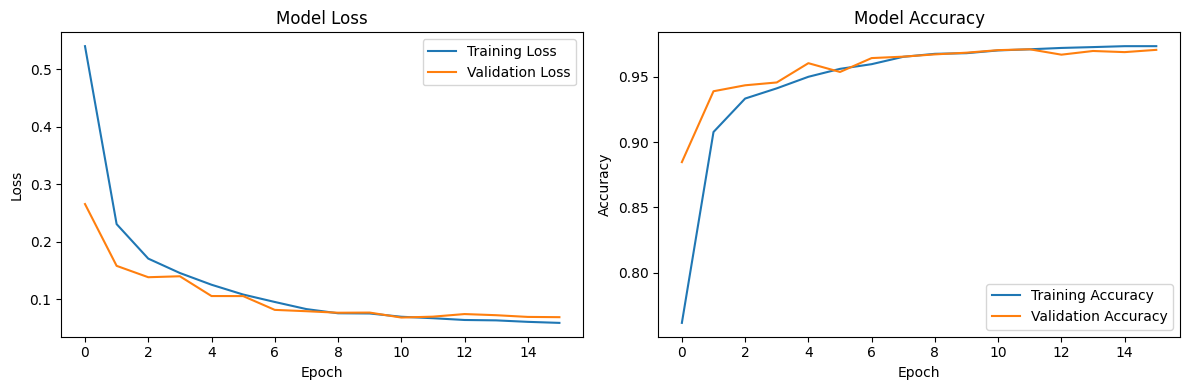

In [76]:
# Cell 9 - Plot Training History
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [77]:
# Evaluate Model
def evaluate_model(model, X_seq_test, X_feat_test, y_test):
    """Evaluate model performance"""
    test_loss, test_accuracy = model.evaluate([X_seq_test, X_feat_test], y_test)
    print(f"\nTest accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy

test_loss, test_accuracy = evaluate_model(model, X_seq_test, X_feat_test, y_test)


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9743 - loss: 0.0645

Test accuracy: 0.9696


In [78]:
# Predict Password Strength

def predict_password(model, password, tokenizer, max_length):
    """Predict the strength of a single password"""
    # Preprocess
    sequence = tokenizer.texts_to_sequences([password])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Extract features
    features = np.array([[len(password),
        sum(c.isupper() for c in password),
        sum(c.islower() for c in password),
        sum(c.isdigit() for c in password),
        sum(not c.isalnum() for c in password)
    ]])

    # Predict password strength
    prediction = model.predict([padded_sequence, features])
    strength_idx = np.argmax(prediction[0])
    confidence = float(np.max(prediction[0]))

    # Convert numerical strength index to descriptive label
    strength_labels = {0: "lemah", 1: "sedang", 2: "kuat"}
    strength = strength_labels.get(strength_idx, "Tidak diketahui")


   

    return strength, confidence

# Test with new passwords
test_passwords = ["udin", "P@ssw0r#$%&*)$", "Str0ng!P@ssw0r#$%&*)$$%d123"]
for password in test_passwords:
    strength, confidence = predict_password(model, password, tokenizer, max_length)
    print(f"\nPassword: {password}")
    print(f"Strength: {strength}")
    print(f"Confidence: {confidence:.2%}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step

Password: udin
Strength: lemah
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Password: P@ssw0r#$%&*)$
Strength: kuat
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Password: Str0ng!P@ssw0r#$%&*)$$%d123
Strength: kuat
Confidence: 100.00%


In [82]:
# Cell 11 - Predict Password Strength
def predict_password(model, password, tokenizer, max_length):
    """Predict the strength of a single password"""
    # Preprocess
    sequence = tokenizer.texts_to_sequences([password])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Extract features
    features = np.array([[len(password),
        sum(c.isupper() for c in password),
        sum(c.islower() for c in password),
        sum(c.isdigit() for c in password),
        sum(not c.isalnum() for c in password)
    ]])

    # Predict password strength
    prediction = model.predict([padded_sequence, features])
    strength_idx = np.argmax(prediction[0])
    confidence = float(np.max(prediction[0]))

    # Convert numerical strength index to descriptive label
    strength_labels = {0: "lemah", 1: "sedang", 2: "kuat"}
    strength = strength_labels.get(strength_idx, "Tidak diketahui")

    return strength, confidence


while True:
    password = input("Masukkan kata sandi (atau ketik 'exit' untuk keluar): ")
    if password.lower() == 'exit':
        print("Program selesai.")
        break

    strength, confidence = predict_password(model, password, tokenizer, max_length)
    print(f"\nPassword: {password}")
    print(f"Strength: {strength}")
    print(f"Confidence: {confidence:.2%}")


Masukkan kata sandi (atau ketik 'exit' untuk keluar):  ikan


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Password: ikan
Strength: lemah
Confidence: 99.99%


Masukkan kata sandi (atau ketik 'exit' untuk keluar):  ikanudang


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Password: ikanudang
Strength: sedang
Confidence: 70.32%


Masukkan kata sandi (atau ketik 'exit' untuk keluar):  udangbatu*!&@&!*


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

Password: udangbatu*!&@&!*
Strength: kuat
Confidence: 100.00%


Masukkan kata sandi (atau ketik 'exit' untuk keluar):  exit


Program selesai.
